### Import Packages

In [225]:
import numpy as np
import pandas as pd
import json
import requests
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import datetime
import folium
from folium import plugins

from pandas.io.json import json_normalize
%matplotlib inline

### Load 1 Year of Data

In [2]:
# startDate = "2017-01-01"
# datelist = pd.date_range(pd.to_datetime(startDate), periods=366).tolist() #1 year of data

In [3]:
# requestsDataFrame = pd.DataFrame()

# for index in range(len(datelist)-1):
#     day = str(datelist[index].date())
#     nextDay = str(datelist[index+1].date())
#     url = """https://secure.toronto.ca/webwizard/ws/requests.json?start_date=""" + day + """T00:00:00Z&end_date=""" + nextDay + """T00:00:00Z&jurisdiction_id=toronto.ca"""
#     response = requests.get(url)
#     response = json_normalize(response.json()['service_requests'])
#     assert response.shape[0] < 1000
#     requestsDataFrame = pd.concat([requestsDataFrame, response])

In [38]:
# requestsDataFrame.to_pickle("./rawData.pkl")

In [197]:
requestsDataFrame = pd.read_pickle("rawData.pkl")

### Basic data cleaning

In [198]:
requestsDataFrame.reset_index(inplace = True)
requestsDataFrame.drop(['index'], axis = 1, inplace = True)

In [199]:
requestsDataFrame.requested_datetime = pd.to_datetime(requestsDataFrame.requested_datetime).dt.date
requestsDataFrame.expected_datetime = pd.to_datetime(requestsDataFrame.expected_datetime).dt.date
requestsDataFrame.updated_datetime = pd.to_datetime(requestsDataFrame.updated_datetime).dt.date

In [200]:
#remove duplicate service_request_id's -> take latest updated datetime
rows = requestsDataFrame.groupby("service_request_id")['updated_datetime'].transform(max) == requestsDataFrame['updated_datetime']
requestsDataFrame = requestsDataFrame[rows]

requestsDataFrame = requestsDataFrame.drop_duplicates()

### Assertions

In [201]:
#check if no duplicate service_request_id's
assert requestsDataFrame.shape[0] == len(requestsDataFrame['service_request_id'].unique())

In [202]:
# Ensure number of days == 365
assert len(pd.to_datetime(requestsDataFrame.requested_datetime).dt.date.unique()) == 365

### EDA

In [203]:
columns = ["service_request_id", "lat", "long", "service_name", "requested_datetime", "expected_datetime",
           "updated_datetime", "status", "status_notes"]
requestsDataFrame = requestsDataFrame[columns]

In [220]:
pd.DataFrame(requestsDataFrame.groupby('service_name')['service_name'].count())

,service_name
service_name,
Bridge - Graffiti Complaint,363
Graffiti,2127
Litter / Bin / Graffiti on Bin,22
Road - Graffiti Complaint,111
Road - Pot hole,11511
Sidewalk - Graffiti Complaint,284


In [221]:
pd.DataFrame(requestsDataFrame.groupby('status')['status'].count())

,status
status,
closed,14212
open,206


In [222]:
pd.DataFrame(requestsDataFrame.groupby('status_notes')['status_notes'].count())

,status_notes
status_notes,
"Cancelled - The request may be a duplicate, work is previously scheduled or no work is required.",363
Completed - The request has been concluded.,13849
In progress - The request has been scheduled.,30
"In progress - The request is being investigated, assessed and/or responded to; additional work may be required, if applicable.",176


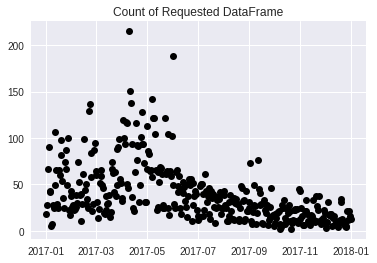

In [290]:
#Count of Requested Date
requestedDate = pd.DataFrame(requestsDataFrame.groupby(['requested_datetime'])['requested_datetime'].count())
fig, ax = plt.subplots()
ax.plot(requestedDate['requested_datetime'].index, requestedDate['requested_datetime'].values,'o', color='black')
ax.set_title('Count of Requested DataFrame')

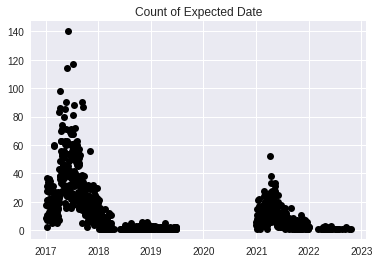

In [382]:
#Count of Expected Date
expectedDate = pd.DataFrame(requestsDataFrame.groupby(['expected_datetime'])['expected_datetime'].count())
fig, ax = plt.subplots()
ax.plot(expectedDate['expected_datetime'].index, expectedDate['expected_datetime'].values,'o', color='black')
ax.set_title('Count of Expected Date')

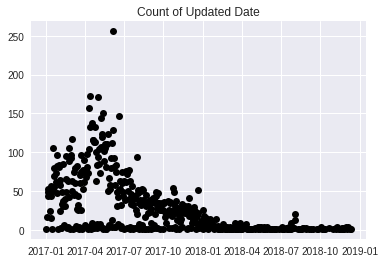

In [288]:
#Count of Updated Date
updatedDate = pd.DataFrame(requestsDataFrame.groupby(['updated_datetime'])['updated_datetime'].count())
fig, ax = plt.subplots()
ax.plot(updatedDate['updated_datetime'].index, updatedDate['updated_datetime'].values,'o', color='black')
ax.set_title('Count of Updated Date')

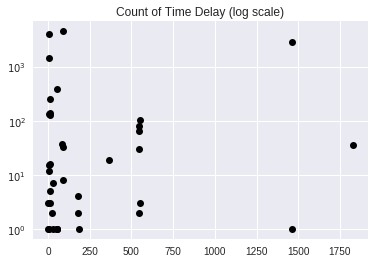

In [338]:
#Count of Time Delay In Days (expected time vs. requestedtime)
requestsDataFrame['TimeDelay'] = requestsDataFrame['expected_datetime']-requestsDataFrame['requested_datetime']
requestsDataFrame['TimeDelay'] = requestsDataFrame['TimeDelay'].dt.days
TimeDelay = pd.DataFrame(requestsDataFrame.groupby(['TimeDelay'])['TimeDelay'].count())

plt.yscale('log')

In [324]:
#Expected Number of Days To Complete
pd.DataFrame(requestsDataFrame.groupby('service_name')['TimeDelay'].mean())

,TimeDelay
service_name,
Bridge - Graffiti Complaint,52.931129
Graffiti,8.385230
Litter / Bin / Graffiti on Bin,13.318182
Road - Graffiti Complaint,34.189189
Road - Pot hole,418.814960
Sidewalk - Graffiti Complaint,33.169014


In [337]:
#Expected Number of Days To Complete (Closed Only)
pd.DataFrame(requestsDataFrame[requestsDataFrame["status"] == "closed"].groupby('service_name')['TimeDelay'].mean())

,TimeDelay
service_name,
Bridge - Graffiti Complaint,52.931129
Graffiti,8.380134
Litter / Bin / Graffiti on Bin,13.318182
Road - Graffiti Complaint,34.189189
Road - Pot hole,408.862382
Sidewalk - Graffiti Complaint,31.931655


In [343]:
requestsDataFrame["long"][0]

-79.404202533000003

In [345]:
#log and lat and then comapre log/lat to time delay

In [394]:
#map first point
points = requestsDataFrame[['lat', 'long']].dropna().as_matrix()
m = folium.Map([points[:, 0].mean(), points[:, 1].mean()], zoom_start=11)
m.add_child(plugins.HeatMap(points, radius=15))
m